<div style="background-color:#05282c; padding:20px; text-align:center;">
    <h1 style="color:white;">MAKING OF BILSTM MODEL FOR ARABIC FAKE NEWS DETECTION</h1>
       <h5 style="color:white;">A PART OF NLP 3 MODELs IMPLIMENTATION PROJECT</h5>
    
</div>


In [37]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional
import sklearn

<div style="background-color:#094a52; padding:20px;">
   <h1 style="font-size:24px;">DATA PREPROCESSING</h1>
</div>

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;">READING DATA FRAMES</h5>
</div>


In [38]:
# Read the dataset
df1 = pd.read_csv("/kaggle/input/labeledarticles/labeled_data.csv")

In [39]:
df1.drop_duplicates(subset=['title','text'], inplace=True)

In [40]:
df1.describe()

,title,text,publishing_date,source_num,label
count,373515,373515,373515,373515,373515
unique,363736,362821,285062,103,2
top,نصاف بن علية تتلقّى الجرعة الأولى من لقاح فايزر,احترام خصوصيتك هو أولويتنا\n\nنحن نستخدم ملفات...,2021-05-19T00:00:00,source_65,credible
freq,6,797,845,33706,207018


In [41]:
# Show the head of the DataFrame
print(df1.head())

                                               title  \
0  المنتخب الوطني المغربي لأقل من 20 سنة يخوض تجم...   
1  وزير النقل اعمارة:السرعة عامل مسبب لحوادث السي...   
2    ميسي يؤكد أن الفوز بكأس اسبانيا كان "نقطة تحول"   
3  دبلوماسي مغربي سابق بإسبانيا لـ2M.ma: خطأ مدري...   
4  شركتان، فرنسية وبريطانية تعلنان عن نتائج إيجاب...   

                                                text      publishing_date  \
0  يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...  2021-05-23T00:00:00   
1  ترأس عبد القادر اعمارة، وزير التجهيز و النقل و...  2021-05-22T00:00:00   
2  أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...  2021-05-22T00:00:00   
3  أكّد الدبلوماسي المغربي السابق بإسبانيا، عبد ا...  2021-05-22T00:00:00   
4  أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...  2021-05-17T00:00:00   

  source_num     label  
0   source_1  credible  
1   source_1  credible  
2   source_1  credible  
3   source_1  credible  
4   source_1  credible  


In [42]:
#label
distinct_label = df1['label'].unique()
print("Distinct label:", distinct_label)

Distinct label: ['credible' 'not credible']


In [43]:
#preps for merg
df1['label'] = df1['label'].map({'credible': 'real', 'not credible': 'fake'})

In [44]:
# Read Arabic stop words from text file
with open("/kaggle/input/arabic/Arabic stop words .txt", encoding="utf-8") as file:
    arabic_stopwords = set(file.read().splitlines())

In [45]:
""" 
# Getting the Arabic stopwords from NLTK
stop_words = set(stopwords.words('arabic'))
"""

" \n# Getting the Arabic stopwords from NLTK\nstop_words = set(stopwords.words('arabic'))\n"

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">stripping the text of ponctuations, links ,emojis and irrigular pattrens</h5>
</div>


In [46]:
# Function to clean the text
def clean_text(text):
    # Remove links
    text = re.sub(r'http\S+', '', text)
    
    # Remove emojis and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    
    # Remove specific patterns like ":\n\n1"
    text = re.sub(r':\n\n\d+', '', text)
    
    # Remove empty spaces
    text = text.strip()
    
    return text

# Clean the text column
df1['cleaned_text'] = df1['text'].apply(clean_text)


# Function to remove Arabic stop words
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)

# Remove Arabic stop words
df1['cleaned_text'] = df1['cleaned_text'].apply(remove_stopwords)

# Show the head of the DataFrame with cleaned text
print(df1[['text', 'cleaned_text']].head())


                                                text  \
0  يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...   
1  ترأس عبد القادر اعمارة، وزير التجهيز و النقل و...   
2  أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...   
3  أكّد الدبلوماسي المغربي السابق بإسبانيا، عبد ا...   
4  أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...   

                                        cleaned_text  
0  يخوض المنتخب الوطني المغربي لكرة القدم لأقل 20...  
1  ترأس عبد القادر اعمارة وزير التجهيز النقل اللو...  
2  أكد النجم الارجنتيني ليونيل ميسي فوز فريقه برش...  
3  أكد الدبلوماسي المغربي بإسبانيا عبد الخالق أطر...  
4  أعلنت شركتا سانوفي الفرنسية العملاقة تصنيع الأ...  


In [47]:
# Show the head of the DataFrame
print(df1.head())
#pd.set_option('display.max_colwidth', None)

                                               title  \
0  المنتخب الوطني المغربي لأقل من 20 سنة يخوض تجم...   
1  وزير النقل اعمارة:السرعة عامل مسبب لحوادث السي...   
2    ميسي يؤكد أن الفوز بكأس اسبانيا كان "نقطة تحول"   
3  دبلوماسي مغربي سابق بإسبانيا لـ2M.ma: خطأ مدري...   
4  شركتان، فرنسية وبريطانية تعلنان عن نتائج إيجاب...   

                                                text      publishing_date  \
0  يخوض المنتخب الوطني المغربي لكرة القدم لأقل من...  2021-05-23T00:00:00   
1  ترأس عبد القادر اعمارة، وزير التجهيز و النقل و...  2021-05-22T00:00:00   
2  أكد النجم الارجنتيني ليونيل ميسي أن فوز فريقه ...  2021-05-22T00:00:00   
3  أكّد الدبلوماسي المغربي السابق بإسبانيا، عبد ا...  2021-05-22T00:00:00   
4  أعلنت شركتا سانوفي الفرنسية العملاقة في تصنيع ...  2021-05-17T00:00:00   

  source_num label                                       cleaned_text  
0   source_1  real  يخوض المنتخب الوطني المغربي لكرة القدم لأقل 20...  
1   source_1  real  ترأس عبد القادر اعمارة وزير التجهيز 

In [48]:
df1.describe()

,title,text,publishing_date,source_num,label,cleaned_text
count,373515,373515,373515,373515,373515,373515
unique,363736,362821,285062,103,2,360433
top,نصاف بن علية تتلقّى الجرعة الأولى من لقاح فايزر,احترام خصوصيتك هو أولويتنا\n\nنحن نستخدم ملفات...,2021-05-19T00:00:00,source_65,real,احترام خصوصيتك أولويتنا نستخدم ملفات تعريف الا...
freq,6,797,845,33706,207018,797


In [49]:
df2 = pd.read_csv("/kaggle/input/arabic/cleaned_merged_data.csv")

In [50]:
df2.head()

,Title,Label,Topic,Origine,Article_date,Article_content,Article_correction,Article_content_cleaned,Article_correction_cleaned
0,54 عاما في القضاء.. نهاية حزينة لمعركة مقدسي ح...,real,politics,df1,NaN,القدس المحتلة- لن يتمكن المقدسي سامي درويش في ...,NaN,القدس المحتلة- لن يتمكن المقدسي سامي درويش في ...,NaN
1,خبراء إيرانيون يشرحون لماذا لا تستعجل طهران با...,real,politics,df1,NaN,طهران- منذ الهجوم الإسرائيلي على القنصلية الإي...,NaN,طهران- منذ الهجوم الإسرائيلي على القنصلية الإي...,NaN
2,فلسطيني يقود فريق خبراء بإيطاليا لبناء قضية إب...,real,politics,df1,NaN,غادر المحامي الفلسطيني راجي صوراني قطاع غزة رف...,NaN,غادر المحامي الفلسطيني راجي صوراني قطاع غزة رف...,NaN
3,مستوطنون يهاجمون قرى نابلس بحماية من جنود الاح...,real,politics,df1,NaN,نابلس- لليوم الثاني على التوالي، تتعرض قرية دو...,NaN,نابلس- لليوم الثاني على التوالي، تتعرض قرية دو...,NaN
4,جدل قانوني حول ترشح جاكوب زوما لانتخابات جنوب ...,real,politics,df1,NaN,بريتوريا- تقدمت اللجنة المستقلة للانتخابات في ...,NaN,بريتوريا- تقدمت اللجنة المستقلة للانتخابات في ...,NaN


In [51]:
df2.describe()

,Title,Label,Topic,Origine,Article_date,Article_content,Article_correction,Article_content_cleaned,Article_correction_cleaned
count,5734,5735,938,5735,5568,5735,2225,5735,2225
unique,5734,2,10,2,2927,5717,2225,5717,2225
top,هذا المقطع يصور طقوسًا دينية في الهند، وليس حر...,fake,sport,df1,"May. 19, 2021",['الإدعاء'],نشرت إحدى حسابات فيسبوك الادعاء بتاريخ 4 يناير...,['الإدعاء'],نشرت إحدى حسابات فيسبوك الادعاء بتاريخ 4 يناير...
freq,1,3115,336,5721,22,11,1,11,1


In [52]:
df2.drop_duplicates(subset=['Title','Article_content'], inplace=True)

In [53]:
df2.describe()

,Title,Label,Topic,Origine,Article_date,Article_content,Article_correction,Article_content_cleaned,Article_correction_cleaned
count,5734,5735,938,5735,5568,5735,2225,5735,2225
unique,5734,2,10,2,2927,5717,2225,5717,2225
top,هذا المقطع يصور طقوسًا دينية في الهند، وليس حر...,fake,sport,df1,"May. 19, 2021",['الإدعاء'],نشرت إحدى حسابات فيسبوك الادعاء بتاريخ 4 يناير...,['الإدعاء'],نشرت إحدى حسابات فيسبوك الادعاء بتاريخ 4 يناير...
freq,1,3115,336,5721,22,11,1,11,1


<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">stripping the text of ponctuations, links ,emojis and irrigular pattrens</h5>
</div>


In [54]:
# Merge the dataframes on their titles
merged_df = pd.merge(df1, df2, left_on='title', right_on='Title', how='left')

# Select the required columns
final_df = merged_df[['cleaned_text', 'label', 'Article_correction_cleaned']]

# Rename the columns for consistency
final_df.columns = ['text', 'label', 'correction']

In [55]:
# Display the final dataframe
final_df.head()

,text,label,correction
0,يخوض المنتخب الوطني المغربي لكرة القدم لأقل 20...,real,NaN
1,ترأس عبد القادر اعمارة وزير التجهيز النقل اللو...,real,NaN
2,أكد النجم الارجنتيني ليونيل ميسي فوز فريقه برش...,real,NaN
3,أكد الدبلوماسي المغربي بإسبانيا عبد الخالق أطر...,real,NaN
4,أعلنت شركتا سانوفي الفرنسية العملاقة تصنيع الأ...,real,NaN


In [56]:
final_df_shuffled = final_df.sample(frac=1).reset_index(drop=True)

In [57]:
final_df_shuffled.head()

,text,label,correction
0,كتب متابعات القاهرة واحدة أرخص مدن العالم لعيش...,real,NaN
1,الغنوشي لسعيد باب الحوار مفتوحا رئيس مجلس نواب...,real,NaN
2,أعلن معهد حلب لإعداد المدرسين الخميس إضراب مفت...,fake,NaN
3,وصلت وزيرة الخارجية والتعاون الدولي ليبيا نجلا...,real,NaN
4,استضافت مجموعة وشوشة الإعلامية الفنانة آيتن عا...,fake,NaN


In [58]:
#final_df_shuffled=final_df_shuffled.iloc[:30000]

In [59]:
# 'label' column contains the labels in the DataFrame
final_df_shuffled['label'] = final_df_shuffled['label'].map({'fake': 0, 'real': 1})

In [60]:
# Replace empty strings with NaN
final_df_shuffled['label'].replace('', np.nan, inplace=True)

# Drop rows with NaN in the 'label' column
final_df_shuffled.dropna(subset=['label'], inplace=True)

/tmp/ipykernel_34/4015605588.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df_shuffled['label'].replace('', np.nan, inplace=True)


In [61]:
final_df_shuffled.drop(columns=['correction'], inplace=True)


In [62]:
final_df_shuffled.head()

,text,label
0,كتب متابعات القاهرة واحدة أرخص مدن العالم لعيش...,1
1,الغنوشي لسعيد باب الحوار مفتوحا رئيس مجلس نواب...,1
2,أعلن معهد حلب لإعداد المدرسين الخميس إضراب مفت...,0
3,وصلت وزيرة الخارجية والتعاون الدولي ليبيا نجلا...,1
4,استضافت مجموعة وشوشة الإعلامية الفنانة آيتن عا...,0


In [63]:
#final_df_shuffled=final_df_shuffled.iloc[:30000]

<div style="background-color:#094a52; padding:20px;">
   <h1 style="font-size:24px;">MAKING THE BI-LSTM MODEL</h1>
</div>

In [64]:
# Data Preparation
X = merged_df['text']
y = merged_df['label']

In [65]:
"""
# Remove Arabic stopwords
X = X.apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))
"""

"\n# Remove Arabic stopwords\nX = X.apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))\n"

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">initialisation of the hyper params </h5>
</div>


In [66]:
# Use LabelEncoder to convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [67]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [68]:
# Tokenization and Padding
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [69]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [76]:
max_sequence_length = 512   # Set an appropriate value
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">defining the LSTM layers + dense layers</h5>
</div>


In [77]:
# BiLSTM Model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.1)) #0.2

# Adding Bidirectional LSTM layers
for _ in range(8):
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dense(units= 64, activation='relu'))
model.add(Dense(units= 64, activation='relu'))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=len(np.unique(y_encoded)), activation='softmax'))


* Compiliung the model

In [80]:
# Compile the Model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [81]:
# Print the Model Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Running the model with plots every epoch</h5>
</div>


Default GPU Device: /device:GPU:0
Epoch 1/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 916s 490ms/step - accuracy: 0.7808 - loss: 0.4196 - val_accuracy: 0.8157 - val_loss: 0.3599
Epoch 2/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 913s 489ms/step - accuracy: 0.8293 - loss: 0.3401 - val_accuracy: 0.8232 - val_loss: 0.3405
Epoch 3/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 913s 489ms/step - accuracy: 0.8470 - loss: 0.3125 - val_accuracy: 0.8251 - val_loss: 0.3429
Epoch 4/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 914s 489ms/step - accuracy: 0.8605 - loss: 0.2910 - val_accuracy: 0.8367 - val_loss: 0.3303
Epoch 5/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 914s 489ms/step - accuracy: 0.8687 - loss: 0.2748 - val_accuracy: 0.8398 - val_loss: 0.3231
Epoch 6/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 913s 489ms/step - accuracy: 0.8781 - loss: 0.2580 - val_accuracy: 0.8436 - val_loss: 0.3233
Epoch 7/8
1868/1868 ━━━━━━━━━━━━━━━━━━━━ 914s 489ms/step - accuracy: 0.8849 - loss: 0.2461 - val_accuracy: 0.8429 - val_loss: 0.3244


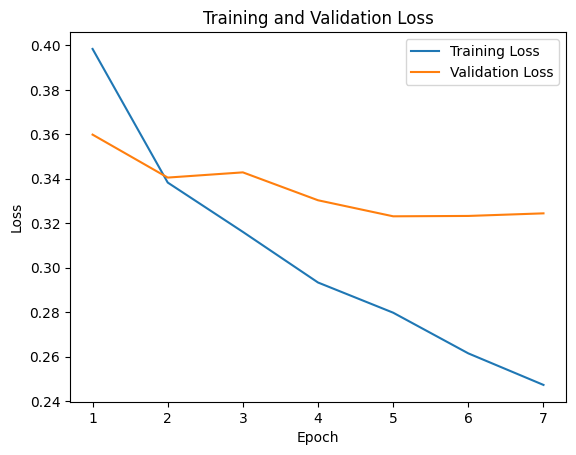

In [83]:
# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("GPU not found. Training on CPU.")

# Train the Model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Lists to store training and validation loss
train_loss = []
val_loss = []

# Ensure the model is using the GPU if available
with tf.device('/device:GPU:0'):
    history = model.fit(X_train_padded, y_train, epochs=8, validation_split=0.2, batch_size=128, shuffle=True, callbacks=[early_stop])
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

# Plotting
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Evaluating the Model</h5>
</div>


In [86]:
# Evaluate the Model
y_pred_probs = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

2335/2335 ━━━━━━━━━━━━━━━━━━━━ 249s 106ms/step
Test Accuracy: 0.8378


<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Repport + confusion Matrix</h5>
</div>


In [87]:
# Evaluate other metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82     33288
           1       0.86      0.85      0.85     41415

    accuracy                           0.84     74703
   macro avg       0.84      0.84      0.84     74703
weighted avg       0.84      0.84      0.84     74703



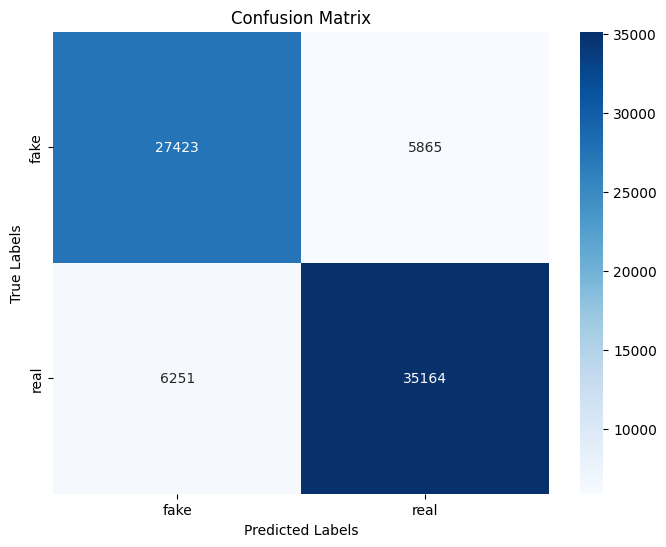

In [90]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color:#3b729a; padding:20px; text-align:center;">
       <h5 style="color:white;text-transform:uppercase;">Saving the model in .h5 format</h5>
</div>


In [ ]:
# Save the model
model.save('BI-LSTM-ARABIC-FAKE-NEWS-DETECTION.h5')

<div style="background-color:#094a52; padding:20px;">
   <h1 style="font-size:24px;">PLOTS</h1>
</div>

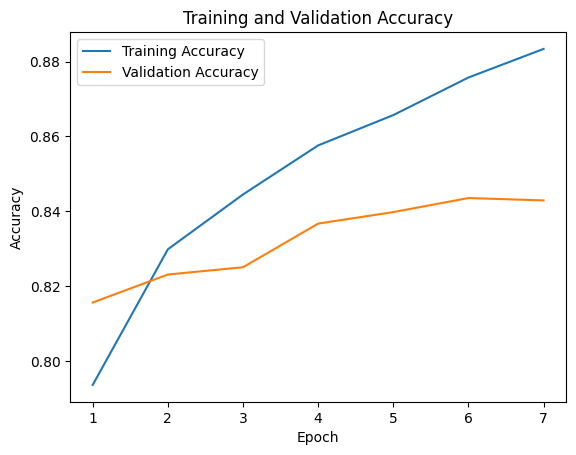

In [98]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

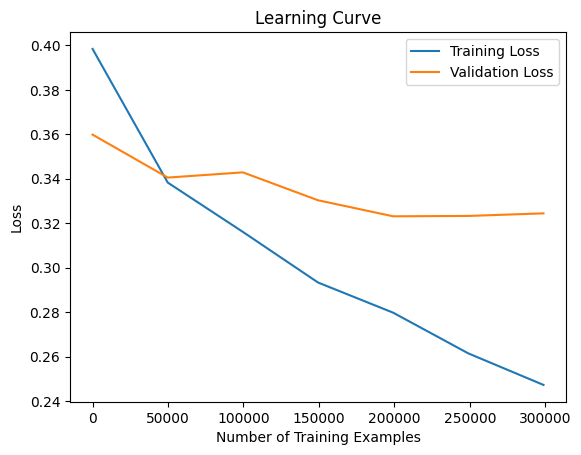

In [99]:
train_size = len(X_train_padded)
plt.plot(np.linspace(0, train_size, len(train_loss)), train_loss, label='Training Loss')
plt.plot(np.linspace(0, train_size, len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Number of Training Examples')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(y_pred_probs[np.where(y_test == y_pred)][:, y_pred], bins=30, alpha=0.5, label='Correct Predictions')
plt.hist(y_pred_probs[np.where(y_test != y_pred)][:, y_pred], bins=30, alpha=0.5, label='Incorrect Predictions')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.legend()
plt.show()
